In [48]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score,recall_score

# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [357]:
telecom = pd.read_csv('telecom_churn_data.csv')

We will perform the following steps in analyzing the data (for __Prediction__ and __Inference__) :-
- Data Cleaning (Handling NULL values , etc.)
- Data Pre-processing
- Data Preparation (Scaling + Splitting into Train/Test)
- Building a model for prediction (using PCA)
- Building a model for inference (without using PCA)
- Presenting the results for recommendation

In [358]:
telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [359]:
telecom.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   mobile_number             99999 non-null  int64  
 1   circle_id                 99999 non-null  int64  
 2   loc_og_t2o_mou            98981 non-null  float64
 3   std_og_t2o_mou            98981 non-null  float64
 4   loc_ic_t2o_mou            98981 non-null  float64
 5   last_date_of_month_6      99999 non-null  object 
 6   last_date_of_month_7      99398 non-null  object 
 7   last_date_of_month_8      98899 non-null  object 
 8   last_date_of_month_9      98340 non-null  object 
 9   arpu_6                    99999 non-null  float64
 10  arpu_7                    99999 non-null  float64
 11  arpu_8                    99999 non-null  float64
 12  arpu_9                    99999 non-null  float64
 13  onnet_mou_6               96062 non-null  float64
 14  onnet

In [361]:
telecom['total_rech_data_6'].describe()

count    25153.000000
mean         2.463802
std          2.789128
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         61.000000
Name: total_rech_data_6, dtype: float64

In [362]:
telecom['total_rech_data_7'].describe()

count    25571.000000
mean         2.666419
std          3.031593
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         54.000000
Name: total_rech_data_7, dtype: float64

In [363]:
telecom['total_rech_amt_6'].describe()

count    99999.000000
mean       327.514615
std        398.019701
min          0.000000
25%        109.000000
50%        230.000000
75%        437.500000
max      35190.000000
Name: total_rech_amt_6, dtype: float64

## Step 1  : Cleaning the data

### Remove columns where the NULL values are more than 50%

In [364]:
df = pd.DataFrame(telecom.isnull().sum())

In [365]:
df.reset_index(level=0, inplace=True)

In [366]:
df.columns = ['Attribute' , 'Null Count']

In [367]:
df = df[df['Null Count'] < 50000]

In [368]:
df['Null Count'].max()

7745

In [369]:
list(df['Attribute'])

['mobile_number',
 'circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'arpu_9',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'onnet_mou_9',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'offnet_mou_9',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_ic_mou_9',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'roam_og_mou_9',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2t_mou_9',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2m_mou_9',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2f_mou_9',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_t2c_mou_9',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_og_mou_9',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2t_mou_9',
 's

In [370]:
len(list(df['Attribute']))

186

In [371]:
selected_columns = list(df['Attribute'])

We will remove all columns of the original dataframe except these 186 coulumns

In [372]:
telecom = telecom[selected_columns]

In [61]:
telecom.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 186 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mobile_number         99999 non-null  int64  
 1   circle_id             99999 non-null  int64  
 2   loc_og_t2o_mou        98981 non-null  float64
 3   std_og_t2o_mou        98981 non-null  float64
 4   loc_ic_t2o_mou        98981 non-null  float64
 5   last_date_of_month_6  99999 non-null  object 
 6   last_date_of_month_7  99398 non-null  object 
 7   last_date_of_month_8  98899 non-null  object 
 8   last_date_of_month_9  98340 non-null  object 
 9   arpu_6                99999 non-null  float64
 10  arpu_7                99999 non-null  float64
 11  arpu_8                99999 non-null  float64
 12  arpu_9                99999 non-null  float64
 13  onnet_mou_6           96062 non-null  float64
 14  onnet_mou_7           96140 non-null  float64
 15  onnet_mou_8       

In [373]:
telecom['last_date_of_month_6'].value_counts()

6/30/2014    99999
Name: last_date_of_month_6, dtype: int64

In [374]:
telecom['circle_id'].value_counts()

109    99999
Name: circle_id, dtype: int64

In [375]:
telecom['date_of_last_rech_6'].value_counts()

6/30/2014    16960
6/29/2014    12918
6/27/2014    11169
6/28/2014     9491
6/26/2014     5530
6/25/2014     4896
6/17/2014     4145
6/24/2014     4129
6/14/2014     3845
6/21/2014     3747
6/23/2014     2908
6/18/2014     2747
6/12/2014     2511
6/22/2014     2344
6/13/2014     2147
6/19/2014     2009
6/20/2014     1803
6/16/2014     1126
6/15/2014      873
6/11/2014      579
6/8/2014       520
6/5/2014       327
6/7/2014       322
6/10/2014      283
6/3/2014       233
6/1/2014       218
6/9/2014       199
6/6/2014       173
6/4/2014       131
6/2/2014       109
Name: date_of_last_rech_6, dtype: int64

### Remove all the useless columns like 'mobile no.' , 'circle_id' , 'last day of month' , 'date of last recharge'

In [376]:
useless_columns = ['mobile_number' , 'circle_id' , 
                   'last_date_of_month_6' , 'last_date_of_month_7' , 
                   'last_date_of_month_8' , 'last_date_of_month_9',
                   'date_of_last_rech_6' , 'date_of_last_rech_7' , 
                   'date_of_last_rech_8' , 'date_of_last_rech_9']

In [377]:
telecom = telecom.drop(columns=useless_columns , axis=1)

In [378]:
telecom.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 176 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loc_og_t2o_mou      98981 non-null  float64
 1   std_og_t2o_mou      98981 non-null  float64
 2   loc_ic_t2o_mou      98981 non-null  float64
 3   arpu_6              99999 non-null  float64
 4   arpu_7              99999 non-null  float64
 5   arpu_8              99999 non-null  float64
 6   arpu_9              99999 non-null  float64
 7   onnet_mou_6         96062 non-null  float64
 8   onnet_mou_7         96140 non-null  float64
 9   onnet_mou_8         94621 non-null  float64
 10  onnet_mou_9         92254 non-null  float64
 11  offnet_mou_6        96062 non-null  float64
 12  offnet_mou_7        96140 non-null  float64
 13  offnet_mou_8        94621 non-null  float64
 14  offnet_mou_9        92254 non-null  float64
 15  roam_ic_mou_6       96062 non-null  float64
 16  roa

### Now we have a final value of 176 columns

## Step 2. Data-preprocessing

### 2.1 Determine the high-value customers (we are interested in only these customers for our analysis)

In [380]:
telecom['avg_rech_in_2months'] = (telecom['total_rech_amt_6'] + telecom['total_rech_amt_7'])/2

In [381]:
quantile_70 = telecom['avg_rech_in_2months'].quantile(q=0.7)

In [382]:
quantile_70

368.5

In [383]:
telecom['avg_rech_in_2months'].quantile(q = [0.05 , 0.1 , 0.25 , 0.5 , 0.75 , 0.9 , 0.95 , 0.99 , 1.0])

0.05       30.0
0.10       60.0
0.25      115.0
0.50      229.0
0.75      419.0
0.90      698.0
0.95      937.5
0.99     1590.0
1.00    37762.5
Name: avg_rech_in_2months, dtype: float64

In [384]:
telecom = telecom[telecom['avg_rech_in_2months'] >= quantile_70]

In [385]:
telecom.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30011 entries, 7 to 99997
Data columns (total 177 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loc_og_t2o_mou       29897 non-null  float64
 1   std_og_t2o_mou       29897 non-null  float64
 2   loc_ic_t2o_mou       29897 non-null  float64
 3   arpu_6               30011 non-null  float64
 4   arpu_7               30011 non-null  float64
 5   arpu_8               30011 non-null  float64
 6   arpu_9               30011 non-null  float64
 7   onnet_mou_6          29695 non-null  float64
 8   onnet_mou_7          29708 non-null  float64
 9   onnet_mou_8          29073 non-null  float64
 10  onnet_mou_9          28307 non-null  float64
 11  offnet_mou_6         29695 non-null  float64
 12  offnet_mou_7         29708 non-null  float64
 13  offnet_mou_8         29073 non-null  float64
 14  offnet_mou_9         28307 non-null  float64
 15  roam_ic_mou_6        29695 non-null

#### Now  we are left with 30011 records (high-value customers) with NULL values

#### Remove the rows which have NULL values in any columns

In [386]:
telecom = telecom.dropna(axis=0 , how='any')

telecom.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27991 entries, 8 to 99997
Data columns (total 177 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loc_og_t2o_mou       27991 non-null  float64
 1   std_og_t2o_mou       27991 non-null  float64
 2   loc_ic_t2o_mou       27991 non-null  float64
 3   arpu_6               27991 non-null  float64
 4   arpu_7               27991 non-null  float64
 5   arpu_8               27991 non-null  float64
 6   arpu_9               27991 non-null  float64
 7   onnet_mou_6          27991 non-null  float64
 8   onnet_mou_7          27991 non-null  float64
 9   onnet_mou_8          27991 non-null  float64
 10  onnet_mou_9          27991 non-null  float64
 11  offnet_mou_6         27991 non-null  float64
 12  offnet_mou_7         27991 non-null  float64
 13  offnet_mou_8         27991 non-null  float64
 14  offnet_mou_9         27991 non-null  float64
 15  roam_ic_mou_6        27991 non-null

#### Now we have 27991 records with no NULL values - all are high-value customers

In [387]:
## Drop the average recharge column
telecom = telecom.drop(columns=['avg_rech_in_2months'])

### 2.2 Tag the churned customers on the basis of the fourth month

In [388]:
telecom.info(verbose=1, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27991 entries, 8 to 99997
Data columns (total 176 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loc_og_t2o_mou      27991 non-null  float64
 1   std_og_t2o_mou      27991 non-null  float64
 2   loc_ic_t2o_mou      27991 non-null  float64
 3   arpu_6              27991 non-null  float64
 4   arpu_7              27991 non-null  float64
 5   arpu_8              27991 non-null  float64
 6   arpu_9              27991 non-null  float64
 7   onnet_mou_6         27991 non-null  float64
 8   onnet_mou_7         27991 non-null  float64
 9   onnet_mou_8         27991 non-null  float64
 10  onnet_mou_9         27991 non-null  float64
 11  offnet_mou_6        27991 non-null  float64
 12  offnet_mou_7        27991 non-null  float64
 13  offnet_mou_8        27991 non-null  float64
 14  offnet_mou_9        27991 non-null  float64
 15  roam_ic_mou_6       27991 non-null  float64
 16  roa

In [394]:
def tag_churners (atb1 , atb2 , atb3 , atb4): 
    if ((atb1 == 0) and (atb2 == 0) and (atb3 == 0) and (atb4 == 0)) :
        return 1
    else :
        return 0

In [395]:
telecom['churn'] = telecom.apply(lambda record : tag_churners(record.total_ic_mou_9 , record.total_og_mou_9 ,
                                                            record.vol_2g_mb_9 , record.vol_3g_mb_9 ) , axis=1)

In [396]:
telecom['churn'].value_counts()

0    27042
1      949
Name: churn, dtype: int64

In [397]:
churn_ratio = sum(telecom['churn'])/len(telecom)
print(churn_ratio)

0.0339037547783216


#### There is a high class-imbalance i.e a churn rate of only 3.39% among High-value customers. <br>Take care of it later on.

In [398]:
telecom.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27991 entries, 8 to 99997
Data columns (total 177 columns):
 #   Column              Dtype  
---  ------              -----  
 0   loc_og_t2o_mou      float64
 1   std_og_t2o_mou      float64
 2   loc_ic_t2o_mou      float64
 3   arpu_6              float64
 4   arpu_7              float64
 5   arpu_8              float64
 6   arpu_9              float64
 7   onnet_mou_6         float64
 8   onnet_mou_7         float64
 9   onnet_mou_8         float64
 10  onnet_mou_9         float64
 11  offnet_mou_6        float64
 12  offnet_mou_7        float64
 13  offnet_mou_8        float64
 14  offnet_mou_9        float64
 15  roam_ic_mou_6       float64
 16  roam_ic_mou_7       float64
 17  roam_ic_mou_8       float64
 18  roam_ic_mou_9       float64
 19  roam_og_mou_6       float64
 20  roam_og_mou_7       float64
 21  roam_og_mou_8       float64
 22  roam_og_mou_9       float64
 23  loc_og_t2t_mou_6    float64
 24  loc_og_t2t_mou_7    float64

### Remove the columns specific to month 9

In [105]:
regex = re.compile('.*_9')
cols_redundant = list(filter(regex.match , telecom.columns))
print(cols_redundant)

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'last_day_rch_amt_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9']


In [106]:
cols_redundant.append('sep_vbc_3g')

In [107]:
len(cols_redundant)

43

In [108]:
telecom = telecom.drop(columns=cols_redundant , axis=1)

In [109]:
telecom.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27991 entries, 8 to 99997
Data columns (total 134 columns):
 #   Column              Dtype  
---  ------              -----  
 0   loc_og_t2o_mou      float64
 1   std_og_t2o_mou      float64
 2   loc_ic_t2o_mou      float64
 3   arpu_6              float64
 4   arpu_7              float64
 5   arpu_8              float64
 6   onnet_mou_6         float64
 7   onnet_mou_7         float64
 8   onnet_mou_8         float64
 9   offnet_mou_6        float64
 10  offnet_mou_7        float64
 11  offnet_mou_8        float64
 12  roam_ic_mou_6       float64
 13  roam_ic_mou_7       float64
 14  roam_ic_mou_8       float64
 15  roam_og_mou_6       float64
 16  roam_og_mou_7       float64
 17  roam_og_mou_8       float64
 18  loc_og_t2t_mou_6    float64
 19  loc_og_t2t_mou_7    float64
 20  loc_og_t2t_mou_8    float64
 21  loc_og_t2m_mou_6    float64
 22  loc_og_t2m_mou_7    float64
 23  loc_og_t2m_mou_8    float64
 24  loc_og_t2f_mou_6    float64

## Step 3. Data Preparation

### No need to create dummy variables as there are no Categorical features

### 3.1 Splitting the data into X and y

In [112]:
X = telecom.drop(columns=['churn'])

In [113]:
y = telecom['churn']

In [114]:
X.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
8,0.0,0.0,0.0,378.721,492.223,137.362,413.69,351.03,35.08,94.66,...,0,0,0,0,0,0,315,21.03,910.65,122.16
13,0.0,0.0,0.0,492.846,205.671,593.260,501.76,108.39,534.24,413.31,...,0,0,0,0,0,0,2607,0.00,0.00,0.00
16,0.0,0.0,0.0,430.975,299.869,187.894,50.51,74.01,70.61,296.29,...,0,0,0,0,0,0,511,0.00,2.45,21.89
17,0.0,0.0,0.0,690.008,18.980,25.499,1185.91,9.28,7.79,61.64,...,0,0,0,0,0,0,667,0.00,0.00,0.00
21,0.0,0.0,0.0,514.453,597.753,637.760,102.41,132.11,85.14,757.93,...,0,0,0,0,0,0,720,0.00,0.00,0.00


In [115]:
y.head()

8     0
13    0
16    0
17    0
21    0
Name: churn, dtype: int64

### 3.2 Splitting into Train/Test

In [116]:
X_train , X_test , y_train , y_test = train_test_split(X , y , train_size=0.75 , test_size=0.25 , stratify = y , random_state=100)

In [118]:
X_train.shape

(20993, 133)

In [119]:
y_train.shape

(20993,)

In [120]:
X_test.shape

(6998, 133)

In [121]:
y_test.shape

(6998,)

In [122]:
### Check the % of churn in Train data
sum(y_train)/len(y_train)

0.03391606726051541

In [123]:
### Check the % of churn in Test data
sum(y_test)/len(y_test)

0.033866819091168905

### 3.3 Scaling the input variables using a Standard Scaler

In [125]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [127]:
X_train_scaled = pd.DataFrame(X_train_scaled , columns=X_train.columns)

In [129]:
X_train_scaled.describe()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
count,20993.0,20993.0,20993.0,2.099300e+04,2.099300e+04,2.099300e+04,2.099300e+04,2.099300e+04,2.099300e+04,2.099300e+04,...,2.099300e+04,2.099300e+04,2.099300e+04,2.099300e+04,2.099300e+04,2.099300e+04,2.099300e+04,2.099300e+04,2.099300e+04,2.099300e+04
mean,0.0,0.0,0.0,2.422111e-16,2.818857e-17,4.082851e-17,-1.135608e-16,7.126307e-17,-3.839479e-18,6.553954e-17,...,6.537163e-16,1.312039e-15,-9.184500e-16,-2.959652e-15,-6.812326e-16,1.585887e-15,6.802119e-17,4.484734e-16,2.427598e-16,-5.604741e-16
std,0.0,0.0,0.0,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,...,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00
min,0.0,0.0,0.0,-6.336872e+00,-5.436332e+00,-2.920114e+00,-6.500802e-01,-6.397926e-01,-5.894965e-01,-9.074123e-01,...,-2.987064e-01,-2.908415e-01,-2.993449e-01,-1.612012e-01,-1.649313e-01,-1.461129e-01,-1.139869e+00,-3.413083e-01,-3.308791e-01,-3.160923e-01
25%,0.0,0.0,0.0,-4.909389e-01,-4.705316e-01,-4.741865e-01,-5.533118e-01,-5.479578e-01,-5.173084e-01,-5.975161e-01,...,-2.987064e-01,-2.908415e-01,-2.993449e-01,-1.612012e-01,-1.649313e-01,-1.461129e-01,-8.270239e-01,-3.413083e-01,-3.308791e-01,-3.160923e-01
50%,0.0,0.0,0.0,-2.064865e-01,-2.038885e-01,-1.772189e-01,-3.641616e-01,-3.718791e-01,-3.606850e-01,-2.843821e-01,...,-2.987064e-01,-2.908415e-01,-2.993449e-01,-1.612012e-01,-1.649313e-01,-1.461129e-01,-3.496305e-01,-3.413083e-01,-3.308791e-01,-3.160923e-01
75%,0.0,0.0,0.0,2.463712e-01,2.252517e-01,2.488423e-01,1.263927e-01,1.161848e-01,7.524412e-02,2.305832e-01,...,-2.987064e-01,-2.908415e-01,-2.993449e-01,-1.612012e-01,-1.649313e-01,-1.461129e-01,7.239969e-01,-3.167321e-01,-3.240244e-01,-3.160923e-01
max,0.0,0.0,0.0,6.051476e+01,7.199562e+01,6.403884e+01,1.488228e+01,1.627908e+01,2.188319e+01,1.726427e+01,...,2.464884e+01,2.534963e+01,2.681672e+01,3.441906e+01,2.758053e+01,4.204150e+01,3.066272e+00,3.269010e+01,2.218782e+01,1.991021e+01


We can see that all the variables have a Standard Deviation of ~1 and a Mean of ~0

## Step 4 : Building a model for Prediction (with PCA)

### 4.1 Use PCA to reduce the no. of variables (dimensionality reduction)

In [131]:
pca = PCA(random_state=42)
pca.fit(X_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [132]:
variance_explained = pca.explained_variance_ratio_

In [133]:
var_cumulative = np.cumsum(variance_explained)

In [134]:
var_cumulative

array([0.09939876, 0.18951595, 0.24792574, 0.29647289, 0.33669239,
       0.37394739, 0.4064423 , 0.43496485, 0.46182223, 0.48697984,
       0.51090003, 0.53360199, 0.55573833, 0.57705106, 0.59726683,
       0.61695651, 0.63377321, 0.65001152, 0.66497878, 0.67903335,
       0.69245763, 0.70433931, 0.71566288, 0.72670131, 0.7371341 ,
       0.74738544, 0.75719068, 0.76661882, 0.77534663, 0.78356828,
       0.79139263, 0.79889519, 0.8062593 , 0.81319418, 0.82005908,
       0.82669482, 0.8332607 , 0.83957779, 0.84577654, 0.85168367,
       0.85753222, 0.86335021, 0.86871789, 0.87393452, 0.87893095,
       0.88387046, 0.88866842, 0.89339016, 0.8978003 , 0.90198418,
       0.90579895, 0.90947244, 0.91308034, 0.91658254, 0.92002619,
       0.92337348, 0.92654607, 0.92966256, 0.93275129, 0.93571537,
       0.9386282 , 0.9414079 , 0.94415523, 0.94679729, 0.94940766,
       0.95195881, 0.95442794, 0.95682938, 0.95912979, 0.96137903,
       0.96352515, 0.96564007, 0.96771263, 0.96972781, 0.97171

Plot the cumulative variance explained to find the no. of components required for 95% variance

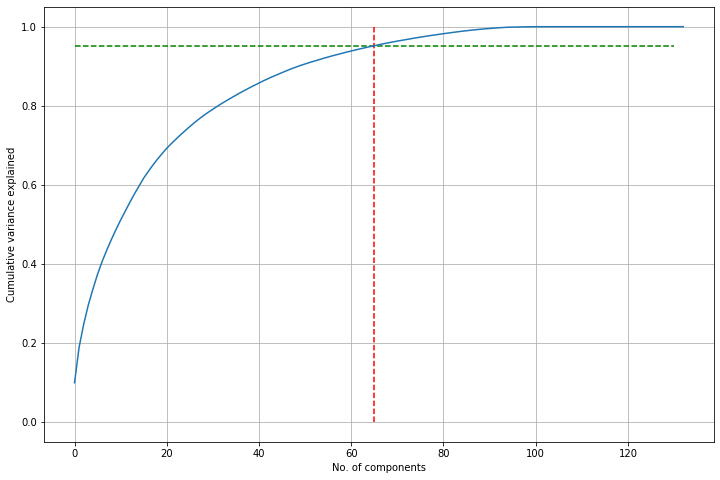

In [139]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=65, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=130, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumulative)
plt.ylabel("Cumulative variance explained")
plt.xlabel("No. of components")
plt.grid()
plt.show()

We can see that no. of components = 65 are able to expain about 95 % variation

In [142]:
pca_final = PCA(n_components=65)
X_train_reduced = pca_final.fit_transform(X_train_scaled)

In [143]:
X_train_reduced.shape

(20993, 65)

Now that we have performed PCA , we will use different Classification models on our training set. <br>
We use GridSearchCv and RandomizedSearchCV for each model to tune the Hyper-parameters for that model.<br>
We are using the following models :-
- Random Forest
- AdaBoost
- XGBoost
<br> We are using 'ROC_AUC' as the scoring parameter because 'accuracy' would not be a good choice due to high class-imbalance
<br> Once we have chosen a model, we will choose the optimum 'Theshold'.

### 4.2 : Use a Random Forest Model

In [146]:

params = {'n_estimators' : [150 , 200],
         'max_depth' : [4,5,6,7],
         'min_samples_split' : [2,4,6],
         'max_features' : [10 ,15 , 20 , 25 , 30]}

rand_forest = RandomForestClassifier()

random_forest_cv = GridSearchCV(estimator=rand_forest,
                         param_grid=params,
                         scoring='roc_auc',
                         verbose=1,
                         return_train_score=True,
                         n_jobs=-1,
                         cv=5)

In [147]:
random_forest_cv.fit(X_train_reduced , y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 46.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [149]:
random_forest_cv.best_params_

{'max_depth': 7,
 'max_features': 15,
 'min_samples_split': 2,
 'n_estimators': 200}

In [150]:
random_forest_cv.best_score_

0.8922991167583076

In [193]:
### Finding out the no. of logical CPUs available to Python Notebook
available_cpus = os.cpu_count()

#### We obtain the best ROC_AUC score of 0.892 using Random Forest

### 4.3 : Use an AdaBoost Classifier

In [194]:

### We will use base_estimator --> DecisionTree with max_depth = 1 & 2
base = [DecisionTreeClassifier(max_depth=1) , DecisionTreeClassifier(max_depth=2)]

params = {'n_estimators' : [150 , 200],
         'learning_rate' : [0.1 , 0.25 , 0.5, 1],
         'base_estimator' : base
         }
adaboost = AdaBoostClassifier()

adaboost_cv = GridSearchCV(estimator=adaboost,
                         param_grid=params,
                         scoring='roc_auc',
                         verbose=1,
                         return_train_score=True,
                         n_jobs=(available_cpus-1),
                         cv=5)

In [195]:
adaboost_cv.fit(X_train_reduced , y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  3.8min
[Parallel(n_jobs=7)]: Done  80 out of  80 | elapsed: 11.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=7,
             param_grid={'base_estimator': [DecisionTreeClassifier(ccp_alpha=0.0,
                                                                   class_weight=None,
                                                                   criterion='gini',
                                                                   max_depth=1,
                                                                   max_features=None,
                                                                   max_leaf_nodes=None,
                                                                   min_impurity_dec...
                                                               

In [196]:
adaboost_cv.best_score_

0.9013158150990641

In [197]:
adaboost_cv.best_params_

{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'learning_rate': 0.1,
 'n_estimators': 200}

#### We obtain the best ROC_AUC score of 0.901 using AdaBoost Classifier

### 4.4 : Use XGBoost Classifier

In [198]:
xgb_classifier = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic')

In [199]:
# A parameter grid for XGBoost
params = {
        'n_estimators' : [150, 200], # no of trees 
        'learning_rate' : [0.02, 0.05, 0.1],  # eta
        'min_child_weight': [1,3],
        'gamma': [0.1, 0.5, 1, 2],
        'subsample': [0.5, 0.7],
        'colsample_bynode': [0.4, 0.7],
        'max_depth': [5, 8]
        }

param_comb = 80

xgb_cv = RandomizedSearchCV(xgb_classifier, 
                                   param_distributions=params, 
                                   n_iter=param_comb, 
                                   scoring='roc_auc', 
                                   n_jobs=(available_cpus-1), 
                                   cv=5, 
                                   verbose=1, 
                                   return_train_score = True,
                                   random_state=42)

In [200]:
xgb_cv.fit(X_train_reduced , y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  1.5min
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:  6.7min
[Parallel(n_jobs=7)]: Done 400 out of 400 | elapsed: 14.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, s...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_i

In [201]:
xgb_cv.best_params_

{'subsample': 0.7,
 'n_estimators': 200,
 'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': 0.05,
 'gamma': 2,
 'colsample_bynode': 0.4}

In [202]:
xgb_cv.best_score_

0.9115751909010055

#### We obtain the best ROC_AUC score of 0.911 using XGBoost Classifier

### Final model chosen for Prediction - XGBoost Classifier

### Correcting class imbalance in XGB Classifier by using the property - 'scale_pos_weight'

In [207]:
ratio_pos_neg = (len(y_train) - sum(y_train))/sum(y_train)
print(ratio_pos_neg)

28.484550561797754


In [208]:
final_model = xgb.XGBClassifier(n_jobs = -1,objective = 'binary:logistic',
                               subsample=0.7,
                               n_estimators=200,
                               min_child_weight=3,
                               max_depth=5,
                               learning_rate=0.05,
                               gamma=2.0,
                               colsample_bynode=0.4,
                               scale_pos_weight=ratio_pos_neg)

In [209]:
final_model.fit(X_train_reduced , y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.4, colsample_bytree=1, gamma=2.0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=28.484550561797754,
              seed=None, silent=None, subsample=0.7, verbosity=1)

### Choosing an optimal Cutoff for our model

#### Create a Dataframe which depicts How Sensitivity and Specificity vary with the the chosen Cutoff

In [210]:
y_train_pred = final_model.predict_proba(X_train_reduced)[:,1]

def calc_pred_labels(y_train_pred , cutoff) :
    predictor = lambda t : 0 if t<cutoff else 1
    vfunc = np.vectorize(predictor)
    return vfunc(y_train_pred)



df = pd.DataFrame(columns = ['Cutoff' , 'Sensitivity' , 'Specificity'])
for i in np.linspace(0.0 , 1.0 , num=21) :
    y_pred_labels = calc_pred_labels(y_train_pred , i)
    conf = confusion_matrix(y_train , y_pred_labels)
    sensitivity = conf[1,1]/(conf[1,1] + conf[1,0])
    specificity = conf[0,0]/(conf[0,0] + conf[0,1])
    df.loc[len(df.index)] = [i , sensitivity , specificity]  
    #df.append(pd.DataFrame([i , sensitivity , specificity] , columns=['Cutoff' , 'Sensitivity' , 'Specificity']))

In [213]:
df

,Cutoff,Sensitivity,Specificity
0,0.00,1.000000,0.000000
1,0.05,1.000000,0.635176
2,0.10,1.000000,0.758395
3,0.15,1.000000,0.819388
4,0.20,1.000000,0.857847
5,0.25,1.000000,0.884128
6,0.30,1.000000,0.904097
7,0.35,1.000000,0.917608
8,0.40,1.000000,0.927814
9,0.45,1.000000,0.937331


#### We can choose an Optimal Cutoff at 0.6 which gives a V. High Sensitivity (0.995) and High Specificity(0.960) for the training set

## Step 5 : Testing our prediction model on Test Data

### 5.1 Preparing the test data - scaling and PCA transformation

In [214]:
X_test_scaled = scaler.transform(X_test)

In [215]:
X_test_reduced = pca_final.transform(X_test_scaled)

In [216]:
final_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=0.4, colsample_bytree=1, gamma=2.0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=28.484550561797754,
              seed=None, silent=None, subsample=0.7, verbosity=1)

### 5.2 : Making Predictions on the test data

In [232]:
## Checking class imbalance for test data
ratio_pos_neg = (len(y_test) - sum(y_test))/sum(y_test)
print(ratio_pos_neg)

28.52742616033755


In [233]:
y_test_pred_prob = final_model.predict_proba(X_test_reduced)[:,1]

In [234]:
roc_auc_score(y_test , y_test_pred_prob)

0.9210332029628854

In [259]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs,
                                              drop_intermediate = True )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(10, 8))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.3f)' % auc_score  , c='red')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - Specificity]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for Test Data')
    plt.grid()
    plt.legend(loc="lower right")
    plt.show()

    return None

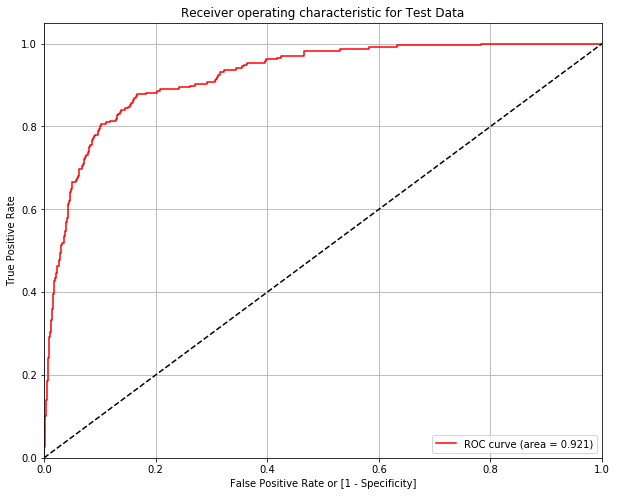

In [260]:
draw_roc(y_test, y_test_pred_prob)

In [238]:
### Calculate Prediction labels
y_test_pred_labels = calc_pred_labels(y_test_pred_prob , cutoff=0.6)

In [239]:
conf = confusion_matrix(y_test, y_test_pred_labels)

In [240]:
### Sensitivity and Specificity
sensitivity = conf[1,1]/(conf[1,1] + conf[1,0])
specificity = conf[0,0]/(conf[0,0] + conf[0,1])
print("Sensitivity for Test Data : " , sensitivity)
print("Specificity for Test Data : " , specificity)

Sensitivity for Test Data :  0.6497890295358649
Specificity for Test Data :  0.9516343736133708


#### Sensitivity is V. low as compared to Specificity
<br> We are interested in correctly predicting the 'Churn' i.e High Sensitivity.
<br> So, we will lower the Cutoff

In [242]:
### Calculate Prediction labels
y_test_pred_labels = calc_pred_labels(y_test_pred_prob , cutoff=0.20)

conf = confusion_matrix(y_test, y_test_pred_labels)

### Sensitivity and Specificity
sensitivity = conf[1,1]/(conf[1,1] + conf[1,0])
specificity = conf[0,0]/(conf[0,0] + conf[0,1])
print("Sensitivity for Test Data : " , sensitivity)
print("Specificity for Test Data : " , specificity)

Sensitivity for Test Data :  0.8523206751054853
Specificity for Test Data :  0.844993344179855


#### Plotting the Precision-Recall Curve for the XGBoost model on the test data

In [339]:
precisions , recalls , thresholds = precision_recall_curve(y_test , y_test_pred_prob)

In [342]:
def plot_precision_recall_curve(p , r , t) :
    plt.plot(t , p[:-1] , 'blue' , label='Precision')
    plt.plot(t , r[:-1] , 'green' , label = 'Recall')
    plt.legend()
    plt.grid()

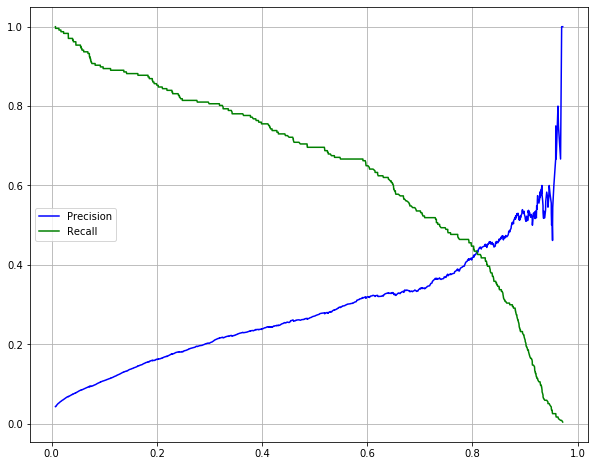

In [349]:
plt.figure(figsize=(10,8))
plot_precision_recall_curve(precisions , recalls , thresholds)
plt.show()

In [347]:
### Calculate the value of Precision and Recall for a cutoff of 0.2
print("Precision for Test data = ", precision_score(y_test , y_test_pred_labels))
print("Recall for Test data = " , recall_score(y_test , y_test_pred_labels))

Precision for Test data =  0.1616
Recall for Test data =  0.8523206751054853


#### Since we want a high Recall (TPR) , the value of cutoff at 0.2 looks OK. <br> Even though the Precision is V. low

## Step 6 : Building a model for Inference (finding important Predictors)

### 6.1 : Use RFE to select the most important features (we can't use PCA here)

In [271]:
### Running RFE to reduce the no. of features to 35
lm = LogisticRegression(max_iter = 500)
lm.fit(X_train_scaled , y_train)
rfe = RFE(lm , n_features_to_select = 35)
rfe = rfe.fit(X_train_scaled, y_train)

In [272]:
list(zip(X_train.columns , rfe.support_ , rfe.ranking_))

[('loc_og_t2o_mou', False, 99),
 ('std_og_t2o_mou', False, 98),
 ('loc_ic_t2o_mou', False, 97),
 ('arpu_6', False, 43),
 ('arpu_7', True, 1),
 ('arpu_8', False, 52),
 ('onnet_mou_6', False, 64),
 ('onnet_mou_7', False, 11),
 ('onnet_mou_8', False, 72),
 ('offnet_mou_6', False, 58),
 ('offnet_mou_7', True, 1),
 ('offnet_mou_8', True, 1),
 ('roam_ic_mou_6', False, 23),
 ('roam_ic_mou_7', False, 70),
 ('roam_ic_mou_8', False, 60),
 ('roam_og_mou_6', False, 87),
 ('roam_og_mou_7', False, 28),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 13),
 ('loc_og_t2t_mou_7', False, 27),
 ('loc_og_t2t_mou_8', False, 7),
 ('loc_og_t2m_mou_6', False, 9),
 ('loc_og_t2m_mou_7', True, 1),
 ('loc_og_t2m_mou_8', False, 5),
 ('loc_og_t2f_mou_6', False, 76),
 ('loc_og_t2f_mou_7', False, 67),
 ('loc_og_t2f_mou_8', True, 1),
 ('loc_og_t2c_mou_6', False, 68),
 ('loc_og_t2c_mou_7', False, 82),
 ('loc_og_t2c_mou_8', False, 61),
 ('loc_og_mou_6', False, 81),
 ('loc_og_mou_7', False, 12),
 ('loc_og_mou_8'

In [273]:
rfe_selected_features = X_train.columns[rfe.support_]
print(rfe_selected_features)
print(len(rfe_selected_features))

Index(['arpu_7', 'offnet_mou_7', 'offnet_mou_8', 'roam_og_mou_8',
       'loc_og_t2m_mou_7', 'loc_og_t2f_mou_8', 'loc_og_mou_8',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_mou_6', 'isd_og_mou_8',
       'spl_og_mou_8', 'og_others_7', 'og_others_8', 'total_og_mou_8',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_7',
       'loc_ic_t2f_mou_8', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_t2t_mou_6',
       'std_ic_t2m_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'ic_others_8',
       'total_rech_num_8', 'total_rech_amt_8', 'last_day_rch_amt_8',
       'vol_2g_mb_8', 'monthly_2g_7', 'monthly_2g_8', 'monthly_3g_7',
       'monthly_3g_8', 'aug_vbc_3g'],
      dtype='object')
35


In [274]:
X_train_rfe = X_train_scaled[rfe_selected_features]

#### Check the VIF for the selected features

In [275]:
### Look at the VIF for all the variables

vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
20,loc_ic_mou_8,2.514953e+09
16,loc_ic_t2m_mou_8,1.240623e+09
15,loc_ic_t2t_mou_8,6.822114e+08
18,loc_ic_t2f_mou_8,5.031189e+07
1,offnet_mou_7,6.791000e+01
7,std_og_t2m_mou_7,5.478000e+01
2,offnet_mou_8,1.854000e+01
8,std_og_t2m_mou_8,1.811000e+01
4,loc_og_t2m_mou_7,1.761000e+01
23,total_ic_mou_8,1.217000e+01


In [276]:
### Remove the feature with the highest VIF
X_train_rfe = X_train_rfe.drop(columns=['loc_ic_mou_8'])

In [277]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,offnet_mou_7,67.89
7,std_og_t2m_mou_7,54.77
2,offnet_mou_8,18.54
8,std_og_t2m_mou_8,18.11
4,loc_og_t2m_mou_7,17.59
22,total_ic_mou_8,12.17
16,loc_ic_t2m_mou_8,7.18
26,total_rech_amt_8,5.38
0,arpu_7,4.52
14,total_og_mou_8,4.49


### 6.2 : Build a Logistic Regression Model with L2 penalty

#### Use class_weight =  ‘balanced’ to handle class-imbalance

In [282]:
log_reg = LogisticRegression(penalty='l2', class_weight='balanced', max_iter=500)
params = {'C' : [0.01 , 0.1 , 1.0 , 10 , 100]}

log_reg_cv = GridSearchCV(estimator=log_reg,
                         param_grid=params,
                         scoring='roc_auc',
                         verbose=1,
                         return_train_score=True,
                         n_jobs = (available_cpus-1),
                         cv=5)

In [283]:
### Check the shape of X and y
print(X_train_rfe.shape)
print(y_train.shape)

(20993, 34)
(20993,)


In [284]:
log_reg_cv.fit(X_train_rfe , y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  25 out of  25 | elapsed:    4.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=7,
             param_grid={'C': [0.01, 0.1, 1.0, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=1)

In [285]:
log_reg_cv.best_params_

{'C': 0.1}

In [286]:
log_reg_cv.best_score_

0.9078055884671196

#### We get a very good ROC-AUC score of 0.907 using Logistic Regression with L2 penalty

In [287]:
### Build a model using the best params and the entire training set
log_reg_final = LogisticRegression(penalty='l2', class_weight='balanced',C = 0.1, max_iter=500)

In [288]:
log_reg_final.fit(X_train_rfe , y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [317]:
### Checking how good the model fit is using Cross-validation
cross_val_score(log_reg_final , X_train_rfe , y_train, cv=5 , scoring = 'roc_auc')

array([0.91225911, 0.92683204, 0.90779265, 0.90829791, 0.88384622])

Now we need to find the most significant Predictor variables

In [289]:
log_reg_coeff = log_reg_final.coef_

In [291]:
log_reg_coeff.shape

(1, 34)

In [292]:
log_reg_coeff = log_reg_coeff.reshape(-1,1)

In [294]:
log_reg_coeff.shape

(34, 1)

In [303]:
coeff_df = pd.DataFrame(columns = ['Feature' , 'Coefficient'])
coeff_df['Feature'] = X_train_rfe.columns
coeff_df['Coefficient'] = log_reg_coeff[:,0]
coeff_df['Abs_coefficient'] = abs(coeff_df['Coefficient'])

In [304]:
coeff_df.sort_values(by='Abs_coefficient', ascending=False)

,Feature,Coefficient,Abs_coefficient
22,total_ic_mou_8,-1.424299,1.424299
24,ic_others_8,-0.720860,0.720860
4,loc_og_t2m_mou_7,-0.699022,0.699022
2,offnet_mou_8,-0.631955,0.631955
3,roam_og_mou_8,0.621587,0.621587
15,loc_ic_t2t_mou_8,-0.561640,0.561640
8,std_og_t2m_mou_8,0.504139,0.504139
10,isd_og_mou_8,-0.489457,0.489457
1,offnet_mou_7,0.471416,0.471416
6,loc_og_mou_8,-0.462300,0.462300


<BarContainer object of 10 artists>

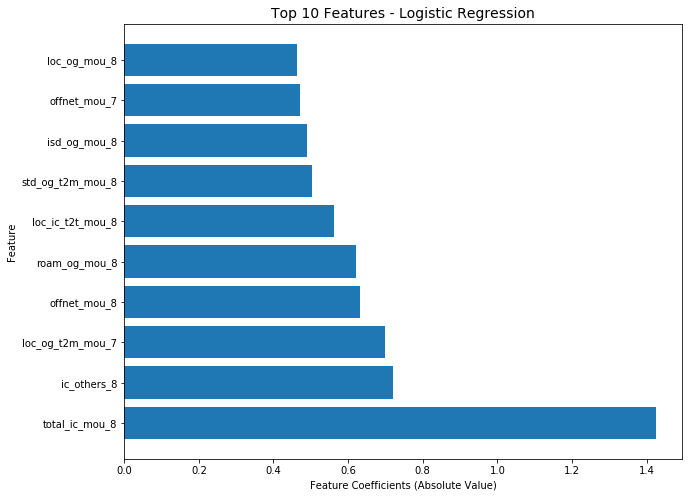

In [356]:
#### PLotiing
df_feature_log_reg = coeff_df.sort_values(by='Abs_coefficient', ascending=False).head(10)
plt.figure(figsize=(10,8))
plt.title('Top 10 Features - Logistic Regression', fontsize=14)
plt.xlabel('Feature Coefficients (Absolute Value)')
plt.ylabel('Feature')
plt.barh(df_feature_log_reg['Feature'] , df_feature_log_reg['Abs_coefficient'])

#### We can note the Top 10 features from the above list . Note that 8 out of Top 10 features are for 3rd Month , i.e. August

### 6.3 : Build a Random Forest Classfier to corroborate the most important features

In [306]:
random_forest_classifier = RandomForestClassifier(max_depth = 7,
                                                  max_features =  10, 
                                                  min_samples_split =  2, 
                                                  n_estimators =  200,
                                                  class_weight = 'balanced')

In [308]:
cross_val_score(random_forest_classifier , X_train_rfe , y_train, cv=5 , scoring = 'roc_auc')

array([0.9585979 , 0.97299692, 0.95802213, 0.95285197, 0.94778037])

In [309]:
random_forest_classifier.fit(X_train_rfe , y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Find out the most important features 

In [310]:
feature_importance = random_forest_classifier.feature_importances_

In [311]:
feature_importance

array([7.31477853e-03, 6.08922415e-03, 1.41347084e-02, 3.84162052e-01,
       8.12685858e-03, 1.45386954e-02, 7.64386717e-02, 1.59371233e-02,
       9.68823177e-03, 1.94975926e-02, 6.99927833e-04, 4.71271269e-03,
       2.19385640e-06, 0.00000000e+00, 4.10750490e-02, 3.93625111e-02,
       1.15509636e-01, 5.42302304e-03, 2.21743958e-02, 8.74867715e-03,
       5.36480120e-03, 1.00690833e-02, 1.28715105e-01, 3.89796034e-03,
       1.70685700e-03, 5.76311382e-03, 1.15093081e-02, 1.64942722e-02,
       1.17143000e-02, 1.18800495e-03, 2.11403413e-03, 5.06417695e-04,
       1.84167157e-03, 5.47900797e-03])

In [325]:
df_feature_importance = pd.DataFrame(columns=['Feature' , 'Importance'])
df_feature_importance['Feature'] = X_train_rfe.columns
df_feature_importance['Importance'] = feature_importance

In [326]:
df_feature_importance.sort_values(by='Importance' , ascending=False)

,Feature,Importance
3,roam_og_mou_8,0.384162
22,total_ic_mou_8,0.128715
16,loc_ic_t2m_mou_8,0.115510
6,loc_og_mou_8,0.076439
14,total_og_mou_8,0.041075
15,loc_ic_t2t_mou_8,0.039363
18,loc_ic_t2f_mou_8,0.022174
9,std_og_mou_6,0.019498
27,last_day_rch_amt_8,0.016494
7,std_og_t2m_mou_7,0.015937


#### Top 10 feaures in this list are similar to the ones obtained by Logistic Regression

Text(0, 0.5, 'Feature')

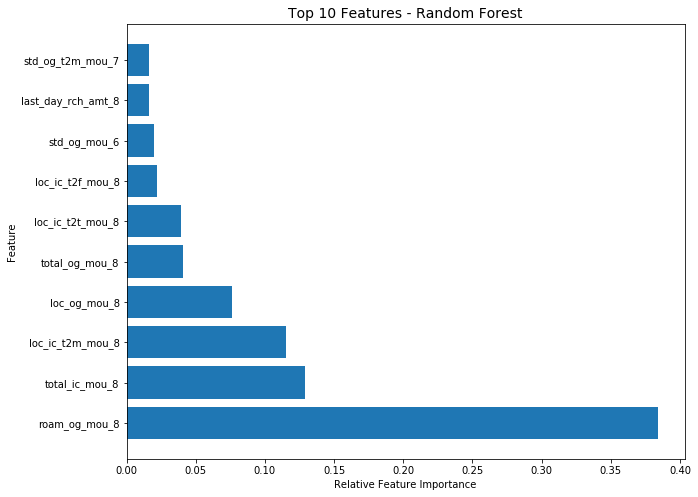

In [355]:
#### PLotiing
df_feature_random_forest = df_feature_importance.sort_values(by='Importance', ascending=False).head(10)
plt.figure(figsize=(10,8))
plt.barh(df_feature_random_forest['Feature'] , df_feature_random_forest['Importance'])
plt.title('Top 10 Features - Random Forest' , fontsize=14)
plt.xlabel('Relative Feature Importance')
plt.ylabel('Feature')

In [322]:
sum(df_feature_importance['Importance'])

0.9999999999999999

### 6.4 : Visualizing the impact of Important Predictors on Customer Churn

We will be using Boxplot for visualization - with the target on X-axis (since it is categorical) <br>
Following features (among Top 10) are shown :-
- roam_og_mou_8
- total_ic_mou_8
- loc_ic_t2m_mou_8
- loc_og_mou_8
- std_og_mou_6

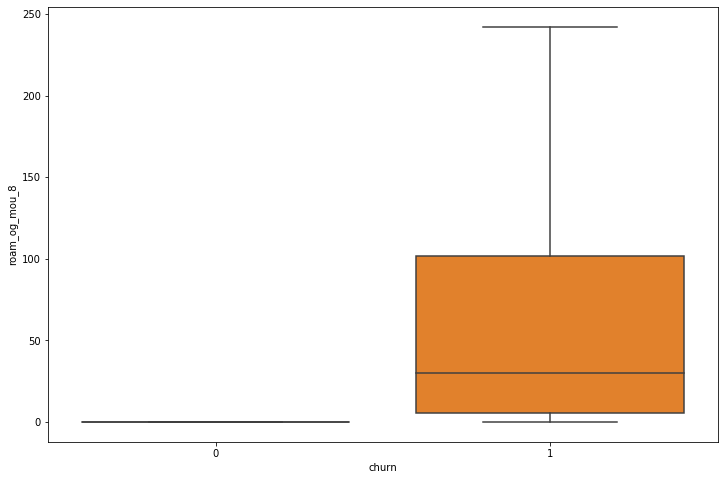

In [404]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'churn', y = 'roam_og_mou_8', data = telecom , showfliers=False)

The feature  __roam_og_mou_8__  has a +ve coefficient in Logistic Regression , thus greater the value , greater is the chance of Churn

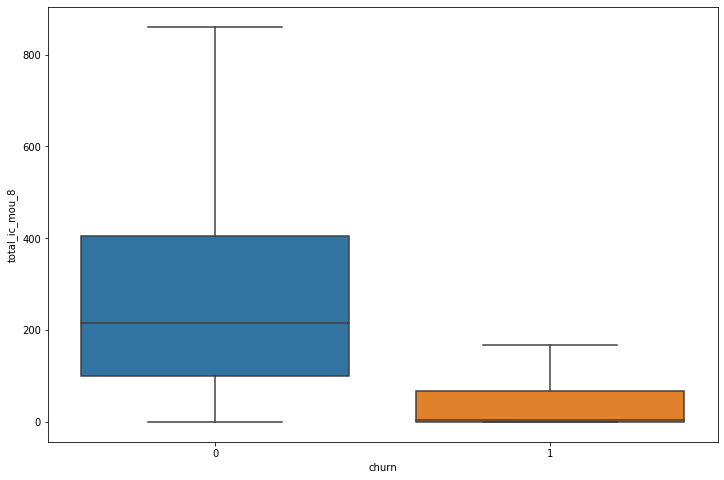

In [405]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'churn', y = 'total_ic_mou_8', data = telecom , showfliers=False)

The feature __total_ic_mou_8__  has a -ve coefficient in Logistic Regression , thus greater the value , lower is the chance of Churn

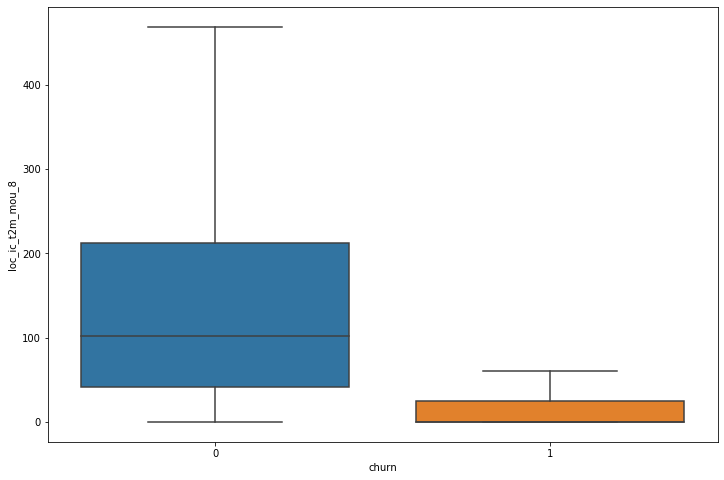

In [413]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'churn', y = 'loc_ic_t2m_mou_8', data = telecom , showfliers=False)    

The feature __loc_ic_t2m_mou_8__ has a -ve coefficient in Logistic Regression , thus greater the value , lower is the chance of Churn

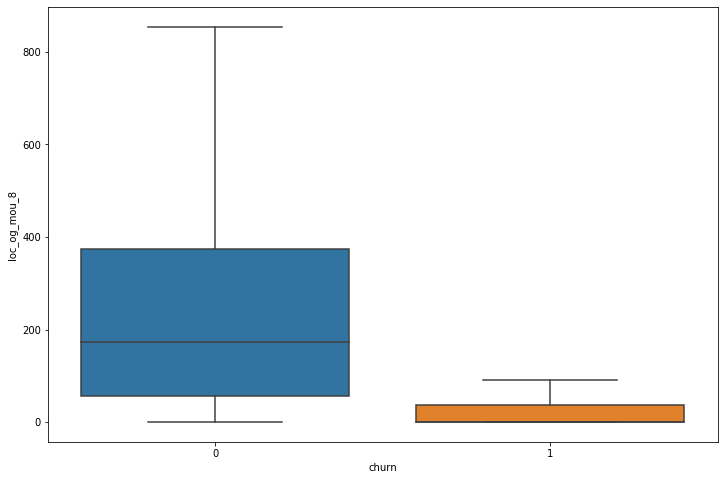

In [416]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'churn', y = 'loc_og_mou_8', data = telecom , showfliers=False) 

The feature __loc_og_mou_8__ has a -ve coefficient in Logistic Regression , thus greater the value , lower is the chance of Churn

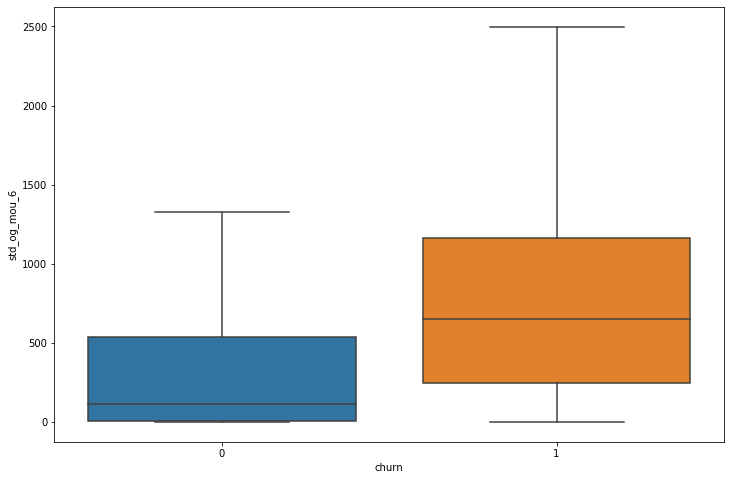

In [409]:
plt.figure(figsize = (12,8))
sns.boxplot(x = 'churn', y = 'std_og_mou_6', data = telecom , showfliers=False) 

The feature __std_og_mou_6__ has a +ve coefficient in Logistic Regression , thus greater the value , greater is the chance of Churn

### 6.5 : Recommendations 

To identify possible Churns by the end of 3rd month, these 2 variables should be carefully monitored :-
- roam_og_mou_8 : Outgoing calls in roaming mode
- std_og_mou_6 : STD outgoing calls 
<br>If customer is using his network heavily on these 2 parameters, there is a good chance that he will move to another telecom network.